# Multi-year IMS Snow Dynamics for Canada
- Create with interannualSnowDynamics()
- Visualize interannual and yearly

In [1]:
import numpy as np
#import hvplot.xarray
import xarray as xr
import geopandas as gpd
import math

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Visualization/Utilities')
import Viz_Utils as vutil

In [2]:
from dask.distributed import LocalCluster

cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing
client = cluster.get_client()
client # Can open in other window by clicking 'Dashboard' link below

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 100,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56823,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 100
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56875,Total threads: 10
Dashboard: http://127.0.0.1:56892/status,Memory: 0 B
Nanny: tcp://127.0.0.1:56826,


2025-02-18 11:55:58,985 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:58,998 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,008 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,016 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,023 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,030 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,041 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,051 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,062 - distributed.nanny - WARNING - Restarting worker
2025-02-18 11:55:59,069 - distributed.nanny - WARNING - Restarting worker


In [3]:
roi = gpd.read_file(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\UtilityData\Study Areas\Canada\Boundary\CanVec\CanVec_Dissolve3979_Buffer10km_Erase_Edit_FillHoles.shp", engine = 'pyogrio')
roi

,ctry_en,ORIG_FID,geometry
0,Canada,0,"MULTIPOLYGON (((2720695.69 188052.83, 2720041...."


# Create multi-year snow dynamics dataset

In [4]:
path = r'C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\IMS (1 km)\Outputs'
ID = 'winterYear'
names = ['start', 'end', 'length', 'periods', 'status']

In [5]:
%%time
snowDynamics = pputil.uploadGT(path, ID, form = 'snowDynamics', names = names)
snowDynamics
# Technically, snow_length should be uint16, snow_periods should be uint8, snow_status should be uint8... but below changed to float32 anyway... 

CPU times: total: 266 ms
Wall time: 2.84 s


<xarray.Dataset> Size: 3GB
Dimensions:       (x: 5372, y: 4568, winterYear: 6)
Coordinates:
  * x             (x) float64 43kB -2.351e+06 -2.35e+06 ... 3.019e+06 3.02e+06
  * y             (y) float64 37kB 3.843e+06 3.842e+06 ... -7.229e+05 -7.239e+05
    spatial_ref   int64 8B 0
    band          int64 8B 1
  * winterYear    (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
Data variables:
    snow_start    (winterYear, y, x) float32 589MB dask.array<chunksize=(1, 79, 5372), meta=np.ndarray>
    snow_end      (winterYear, y, x) float32 589MB dask.array<chunksize=(1, 79, 5372), meta=np.ndarray>
    snow_length   (winterYear, y, x) float32 589MB dask.array<chunksize=(1, 79, 5372), meta=np.ndarray>
    snow_periods  (winterYear, y, x) float32 589MB dask.array<chunksize=(1, 79, 5372), meta=np.ndarray>
    snow_status   (winterYear, y, x) float32 589MB dask.array<chunksize=(1, 79, 5372), meta=np.ndarray>

In [6]:
#snowDynamics.nbytes / 1e9 # 2.9 GB

In [7]:
%%time
snowDynamics = pputil.loadXR(snowDynamics)
snowDynamics

CPU times: total: 16.7 s
Wall time: 35 s


<xarray.Dataset> Size: 3GB
Dimensions:       (x: 5372, y: 4568, winterYear: 6)
Coordinates:
  * x             (x) float64 43kB -2.351e+06 -2.35e+06 ... 3.019e+06 3.02e+06
  * y             (y) float64 37kB 3.843e+06 3.842e+06 ... -7.229e+05 -7.239e+05
    spatial_ref   int64 8B 0
    band          int64 8B 1
  * winterYear    (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
Data variables:
    snow_start    (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_end      (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_length   (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_periods  (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_status   (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan

In [8]:
%%time
snowDynamics = snowDynamics.rio.clip(roi.geometry.values, drop = False) # Sets outside border to 0 for uint8 # .astype('float32')

# Next time, could clip here? Or stick with 9
    # da = da.rio.clip(roi.geometry.values)
    # da.rio.write_nodata(-999, encoded = True, inplace = True)

snowDynamics

CPU times: total: 12.1 s
Wall time: 13.4 s


<xarray.Dataset> Size: 3GB
Dimensions:       (x: 5372, y: 4568, winterYear: 6)
Coordinates:
  * x             (x) float64 43kB -2.351e+06 -2.35e+06 ... 3.019e+06 3.02e+06
  * y             (y) float64 37kB 3.843e+06 3.842e+06 ... -7.229e+05 -7.239e+05
    band          int64 8B 1
  * winterYear    (winterYear) <U9 216B '2018-2019' '2019-2020' ... '2023-2024'
    spatial_ref   int64 8B 0
Data variables:
    snow_start    (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_end      (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_length   (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_periods  (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan
    snow_status   (winterYear, y, x) float32 589MB nan nan nan ... nan nan nan

In [9]:
snowDynamics = snowDynamics.sel(winterYear = ['2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023']) # For paper don't use 2023-2024

In [10]:
#vutil.matrixPlot(snowDynamics['snow_start'], form = 'ims_dynamics', range = [-100,0])
# For start and end need to fill in NaN with perennial/snow free

# interannualSnowDynamics()

In [11]:
%%time
snowDynamics_i = snow_util.interannualSnowDynamics(snowDynamics,
                                                   min_count = 'half',
                                                   products = names,
                                                   uncertainty = [],
                                                   clearObsPerDay = [],
                                                   form = 'mean',
                                                   sd = False,
                                                   quality = False,
                                                   best_value = False,
                                                   verbose = True)
snowDynamics_i

Added snow cover start date to interannual snowDynamics.
Added snow cover end date to interannual snowDynamics.
Added snow cover length to interannual snowDynamics.
Added snow period count to interannual snowDynamics.
Added % years snow-free and with perennial snow to snowDynamics.
CPU times: total: 18.8 s
Wall time: 19.2 s


<xarray.Dataset> Size: 589MB
Dimensions:          (x: 5372, y: 4568)
Coordinates:
  * x                (x) float64 43kB -2.351e+06 -2.35e+06 ... 3.02e+06
  * y                (y) float64 37kB 3.843e+06 3.842e+06 ... -7.239e+05
    spatial_ref      int64 8B 0
    band             int64 8B 1
Data variables:
    snow_start_mn    (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan
    snow_end_mn      (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan
    snow_length_mn   (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan
    snow_periods_mn  (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan
    pPerennialSnow   (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan
    pSnowFree        (y, x) float32 98MB nan nan nan nan nan ... nan nan nan nan

In [12]:
snowDynamics_i.nbytes / 1e9 #1 GB

0.58902264

In [13]:
# vutil.mapCanada(snowDynamics_i['snow_periods_mn'], form = 'raster', label = 'Number of Snow Periods (2018 - 2023 Mean)', range = [0,3], 
#                 cmap = 'viridis') # viridis Spectral Spectral_r

In [14]:
#np.unique(snowDynamics_i['pPerennialSnow'], return_counts = True)

In [15]:
# snowDynamics_i['snow_start_mn'].rio.to_raster('IMS_snow_start_mn_1824.tif')
# snowDynamics_i['snow_start_sd'].rio.to_raster('IMS_snow_start_sd_1824.tif')
# snowDynamics_i['snow_end_mn'].rio.to_raster('IMS_snow_end_mn_1824.tif')
# snowDynamics_i['snow_end_sd'].rio.to_raster('IMS_snow_end_sd_1824.tif')
# snowDynamics_i['snow_length_mn'].rio.to_raster('IMS_snow_length_mn_1824.tif')
# snowDynamics_i['snow_length_sd'].rio.to_raster('IMS_snow_length_sd_1824.tif')
# snowDynamics_i['snow_periods_mn'].rio.to_raster('IMS_snow_periods_mn_1824.tif')
# snowDynamics_i['snow_periods_sd'].rio.to_raster('IMS_snow_periods_sd_1824.tif')
# snowDynamics_i['pPerennialSnow'].rio.to_raster('IMS_pPerennialSnow_1824.tif')
# snowDynamics_i['pSnowFree'].rio.to_raster('IMS_pSnowFree_1824.tif')

# Start/End Categorical Visualization

In [16]:
#snowDynamics_i['snow_start_mn'].plot.hist()
#snowDynamics_i['snow_start_mn'].quantile(0.01) # -113 (Sep 9)
#snowDynamics_i['snow_start_mn'].quantile(0.99) # 18 (Jan 18)

In [17]:
#snowDynamics_i['snow_end_mn'].plot.hist()
#snowDynamics_i['snow_end_mn'].quantile(0.01) # 64 (Mar 5)
#snowDynamics_i['snow_end_mn'].quantile(0.99) # 208 (Jul 27)

In [18]:
# vutil.mapCanadaSnowStartEnd(snowDynamics_i['snow_start_mn'], 'start', snowDynamics_i['pPerennialSnow'], snowDynamics_i['pSnowFree'])

In [19]:
# vutil.mapCanadaSnowStartEnd(snowDynamics_i['snow_end_mn'], 'end', snowDynamics_i['pPerennialSnow'], snowDynamics_i['pSnowFree'])

In [20]:
# vutil.mapCanada(snowDynamics_i['snow_periods_mn'], form = 'raster', label = 'Number of Snow Periods (2018 - 2023 Mean)', range = [0,3], 
#                 cmap = 'viridis', single_plot = False)

In [21]:
#vutil.mapCanadaSnowStartEnd(snowDynamics_i['snow_end_mn'], 'end', snowDynamics_i['pPerennialSnow'], snowDynamics_i['pSnowFree'], single_plot = False)

# Save Figure S8

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

C:\Users\mbonney\AppData\Local\Temp\ipykernel_15168\3969362601.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(h_pad = 0, w_pad = -4.4)


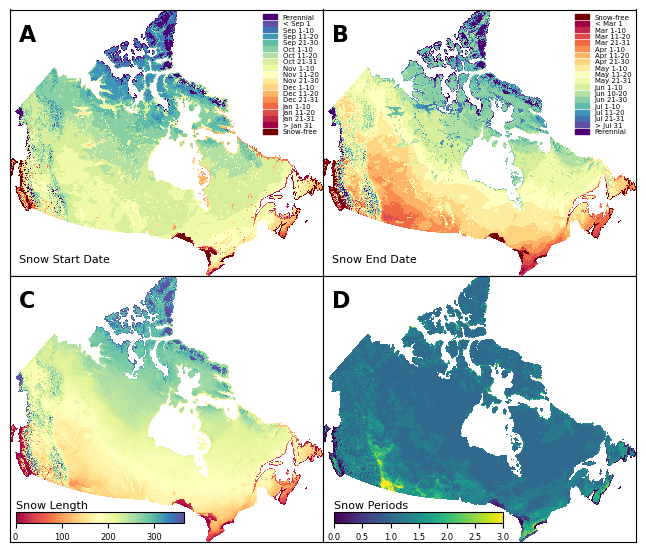

In [28]:
fig, axs = plt.subplots(2, 2, figsize = (7.5, 7.5 * 0.75)) # 3876 pixel width

# A
axs[0, 0].text(-2200000, 3300000, 'A', fontsize = 16, weight = 'bold')
axs[0, 0].text(-2200000, -500000, 'Snow Start Date', fontsize = 8)

vutil.mapCanadaSnowStartEnd(snowDynamics_i['snow_start_mn'], 'start', snowDynamics_i['pPerennialSnow'], snowDynamics_i['pSnowFree'], ax = axs[0, 0], single_plot = False)

colors = ['#4C0073', '#5E4FA2', '#4273B3', '#3F96B7', '#60BBA8', '#88D0A4', '#B2E0A2', '#D7EF9B', '#EFF9A7', '#FFFFBF', 
          '#FEEC9E', '#FED480', '#FDB466', '#F88E52', '#F06744', '#DD4A4C', '#C0274A', '#9E0142', '#730000']
scale = [-1001, -999, -121.5, -111.5, -101.5, -91.5, -81.5, -71.5, -60.5, -50.5, 
        -40.5, -30.5, -20.5, -10.5, -0.5, 10.5, 20.5, 31.5, 999, 1001]
labels = ['Perennial', '< Sep 1', 'Sep 1-10', 'Sep 11-20', 'Sep 21-30', 'Oct 1-10', 'Oct 11-20', 'Oct 21-31', 'Nov 1-10', 'Nov 11-20', 
        'Nov 21-30', 'Dec 1-10', 'Dec 11-20', 'Dec 21-31', 'Jan 1-10', 'Jan 11-20', 'Jan 21-31', '> Jan 31', 'Snow-free']   

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))     

patches = [mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(labels))]

axs[0, 0].legend(handles = patches, loc = 'upper right', borderaxespad = 0.5, fontsize = 5, title = None, frameon = False, labelspacing = 0.05, borderpad = 0.2) # bbox_to_anchor = (0, 0)   

# B
axs[0, 1].text(-2200000, 3300000, 'B', fontsize = 16, weight = 'bold')
axs[0, 1].text(-2200000, -500000, 'Snow End Date', fontsize = 8)

vutil.mapCanadaSnowStartEnd(snowDynamics_i['snow_end_mn'], 'end', snowDynamics_i['pPerennialSnow'], snowDynamics_i['pSnowFree'], ax = axs[0, 1], single_plot = False)

colors = ['#730000', '#9E0142', '#C0274A', '#DD4A4C', '#F06744', '#F88E52', '#FDB466', '#FED480', '#FEEC9E', '#FFFFBF',
          '#EFF9A7', '#D7EF9B', '#B2E0A2', '#88D0A4', '#60BBA8', '#3F96B7', '#4273B3', '#5E4FA2', '#4C0073']
scale = [-1001, -999, 59.5, 69.5, 79.5, 90.5, 100.5, 110.5, 120.5, 130.5, 
         140.5, 151.5, 161.5, 171.5, 181.5, 191.5, 201.5, 212.5, 999, 1001]
labels = ['Snow-free', '< Mar 1', 'Mar 1-10', 'Mar 11-20', 'Mar 21-31', 'Apr 1-10', 'Apr 11-20', 'Apr 21-30', 'May 1-10', 'May 11-20', 
          'May 21-31', 'Jun 1-10', 'Jun 10-20', 'Jun 21-30', 'Jul 1-10', 'Jul 11-20', 'Jul 21-31', '> Jul 31', 'Perennial']

cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(scale, len(colors))

patches = [mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(labels))]

axs[0, 1].legend(handles = patches, loc = 'upper right', borderaxespad = 0.5, fontsize = 5, title = None, frameon = False, labelspacing = 0.05, borderpad = 0.2) # bbox_to_anchor = (0, 0), 

# C
axs[1, 0].text(-2200000, 3300000, 'C', fontsize = 16, weight = 'bold')

vutil.mapCanada(snowDynamics_i['snow_length_mn'], form = 'raster', label = 'Snow Length', range = [0, 365], cmap = 'Spectral', ax = axs[1, 0], single_plot = False)

cbax = fig.add_axes([0.09, 0.06, 0.225, 0.02]) # Left, Bottom, Width, Height
sm = plt.cm.ScalarMappable(cmap = 'Spectral', norm = plt.Normalize(vmin = 0, vmax = 365))
fig.colorbar(sm, cax = cbax, orientation = 'horizontal')
cbax.set_xlabel('Snow Length', labelpad = -30, loc = 'left', size = 8)
cbax.tick_params(labelsize = 6)

# D
axs[1, 1].text(-2200000, 3300000, 'D', fontsize = 16, weight = 'bold')

vutil.mapCanada(snowDynamics_i['snow_periods_mn'], form = 'raster', label = 'Snow Periods', range = [0, 3], cmap = 'viridis', ax = axs[1, 1], single_plot = False)

cbax = fig.add_axes([0.515, 0.06, 0.225, 0.02]) # Left, Bottom, Width, Height
sm = plt.cm.ScalarMappable(cmap = 'viridis', norm = plt.Normalize(vmin = 0, vmax = 3))
fig.colorbar(sm, cax = cbax, orientation = 'horizontal')
cbax.set_xlabel('Snow Periods', labelpad = -30, loc = 'left', size = 8)
cbax.tick_params(labelsize = 6)

plt.tight_layout(h_pad = 0, w_pad = -4.4)

plt.show()

fig.get_figure().savefig('Figure S8_1.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})

## Start (test)

In [72]:
# test = xr.where(snowDynamics_i['pSnowFree'] >= 50, 1000, snowDynamics_i['snow_start_mn'])
# test = xr.where(snowDynamics_i['pPerennialSnow'] >= 50, -1000, test)
# test = xr.where(snowDynamics_i['snow_start_mn'].notnull(), snowDynamics_i['snow_start_mn'], test)
# test

In [73]:
#test.isnull().sum()
#np.unique(test, return_counts = True)

In [74]:
# colors = list(reversed(['#9E0142', '#C0274A', '#DD4A4C', '#F06744', '#F88E52', '#FDB466', '#FED480', '#FEEC9E', '#FFFFBF', '#EFF9A7', '#D7EF9B', '#B2E0A2', 
#           '#88D0A4', '#60BBA8', '#3F96B7', '#4273B3', '#5E4FA2', '#000000', '#828282']))
# colors

In [75]:
# colors = ['#4C0073', '#5E4FA2', '#4273B3', '#3F96B7', '#60BBA8', 
#           '#88D0A4', '#B2E0A2', '#D7EF9B', '#EFF9A7', '#FFFFBF', 
#           '#FEEC9E', '#FED480', '#FDB466', '#F88E52', '#F06744', 
#           '#DD4A4C', '#C0274A', '#9E0142', '#730000']
# scale = [-1001, -999, -121.5, -111.5, -101.5, 
#          -91.5, -81.5, -71.5, -60.5, -50.5, 
#          -40.5, -30.5, -20.5, -10.5, -0.5, 
#          10.5, 20.5, 31.5, 999, 1001]
# labels = ['Usually perennial snow', 'Before September 1', 'September 1-10', 'September 11-20', 'September 21-30', 
#          'October 1-10', 'October 11-20', 'October 21-31', 'November 1-10', 'November 11-20', 
#          'November 21-30', 'December 1-10', 'December 11-20', 'December 21-31', 'January 1-10', 
#          'January 11-20', 'January 21-31', 'After January 31', 'Usually snow-free']

In [76]:
# import matplotlib as mpl

# cmap = mpl.colors.ListedColormap(colors)
# norm = mpl.colors.BoundaryNorm(scale, len(colors))
# cmap

In [77]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches

# fig, ax = plt.subplots(figsize = (10, 7.5))

# test.plot(cmap = cmap, norm = norm, ax = ax, add_labels = False, add_colorbar = False)

# # Hide  axis ticks and labels
# ax.xaxis.set_tick_params(labelbottom = False)
# ax.yaxis.set_tick_params(labelleft = False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_aspect('equal') # Force square pixels

# # Configure colorbar
# patches = [mpatches.Patch(color = colors[i], label = labels[i]) for i in range(len(labels))]
# #patches = [mpatches.Patch(color = colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# plt.legend(handles = patches, bbox_to_anchor = (0.725, 1), loc = 2, borderaxespad = 0, fontsize = 9, 
#            title = 'Snow Season Start Date', title_fontsize = 10, frameon = False, labelspacing = 0.05,
#            borderpad = 0.2)

# plt.show()

# Combine into interannual product
- Will turn into function (interannualSnowDynamics()) - for HLS processing

## Snow Length
- Mean and Standard deviation (No NaNs to worry about)

In [78]:
# %%time
# snow_length_mn = snowDynamics['snow_length'].mean(dim = 'winterYear')
# snow_length_mn

In [79]:
# vutil.mapCanada(snow_length_mn, type = 'raster', label = 'Days with Snow Coverage (2018 - 2023 Mean)', range = [0,365])

In [80]:
# print(str(snow_length_mn.mean().values) + ' ± ' + str(snow_length_mn.std().values))

In [81]:
# snow_length_mn.std()

In [82]:
#snow_length_mn.rio.to_raster('IMS_snow_length_Mean1823.tif')

In [83]:
# %%time
# snow_length_sd = snowDynamics['snow_length'].std(dim = 'winterYear')
# snow_length_sd

In [84]:
# vutil.mapCanada(snow_length_sd, type = 'raster', label = 'Days with Snow Coverage (2018 - 2023 Std)', range = [0,50])

In [85]:
#snow_length_sd.rio.to_raster('IMS_snow_length_Std1823.tif')

In [86]:
# print(str(snow_length_sd.mean().values) + ' ± ' + str(snow_length_sd.std().values))

## Snow Periods
- Mean and Standard deviation (No NaNs to worry about)

In [87]:
# %%time
# snow_periods_mn = snowDynamics['snow_periods'].mean(dim = 'winterYear')
# snow_periods_mn

In [88]:
# vutil.mapCanada(snow_periods_mn, type = 'raster', label = 'Number of Snow Periods (2018 - 2023 Mean)', range = [0,3])

In [89]:
# print(str(snow_periods_mn.mean().values) + ' ± ' + str(snow_periods_mn.std().values))

In [90]:
#snow_periods_mn.rio.to_raster('IMS_snow_periods_Mean1823.tif')

In [91]:
# %%time
# snow_periods_sd = snowDynamics['snow_periods'].std(dim = 'winterYear')
# snow_periods_sd

In [92]:
# vutil.mapCanada(snow_periods_sd, type = 'raster', label = 'Number of Snow Periods (2018 - 2023 Std)', range = [0,2])

In [93]:
#snow_periods_sd.rio.to_raster('IMS_snow_periods_Std1823.tif')

In [94]:
# print(str(snow_periods_sd.mean().values) + ' ± ' + str(snow_periods_sd.std().values))

## Snow Status

In [95]:
#np.unique(snowDynamics['snow_status'], return_counts = True)

In [96]:
# snowDynamics['snow_status']

In [97]:
# %%time
# crs = snowDynamics.rio.crs # Some xarray functions remove crs
# pPerennialSnow = xr.where(snowDynamics['snow_status'] == 2, 1, snowDynamics['snow_status']) # 2 becomes 1 (1 already 1)
# pPerennialSnow = xr.where(pPerennialSnow == 3, 0, pPerennialSnow) # 3 becomes 0
# pPerennialSnow = pPerennialSnow.sum(dim = 'winterYear', skipna = False) / len(snowDynamics) * 100 # Keep NaNs as NaN
# pPerennialSnow.rio.write_crs(crs, inplace = True) # Reapply crs
# pPerennialSnow

In [98]:
# vutil.mapCanada(pPerennialSnow, type = 'raster', label = '% Years with Perennial Snow (2018 - 2023)', range = [0,100])

In [99]:
# print(str(pPerennialSnow.mean().values) + ' ± ' + str(pPerennialSnow.std().values))

In [100]:
# uniques, counts = np.unique(pPerennialSnow, return_counts = True)
# percentages = dict(zip(uniques, counts / (pPerennialSnow.shape[0] * pPerennialSnow.shape[1]) * 100))
# percentages

In [101]:
#pPerennialSnow.rio.to_raster('IMS_pPerennialSnow_1823.tif')

In [102]:
# %%time
# crs = snowDynamics.rio.crs # Some xarray functions remove crs
# pSnowFree = xr.where((snowDynamics['snow_status'] == 2) | ((snowDynamics['snow_status'] == 1)), 0, snowDynamics['snow_status']) # 2 and 1 become 0
# pSnowFree = xr.where(pSnowFree == 3, 1, pSnowFree) # 3 becomes 1
# pSnowFree = pSnowFree.sum(dim = 'winterYear', skipna = False) / len(snowDynamics) * 100 # Keep NaNs as NaN
# pSnowFree.rio.write_crs(crs, inplace = True) # Reapply crs
# pSnowFree

In [103]:
# vutil.mapCanada(pSnowFree, type = 'raster', label = '% Years without Significant Snow (2018 - 2023)', range = [0,100])

In [104]:
#pSnowFree.rio.to_raster('IMS_pSnowFree_1823.tif')

In [105]:
# print(str(pSnowFree.mean().values) + ' ± ' + str(pSnowFree.std().values))

## Snow Start

In [106]:
# %%time
# snow_start_mn = snowDynamics['snow_start'].sum(dim = 'winterYear', min_count = math.ceil(len(snowDynamics) / 2)) / len(snowDynamics)
# snow_start_mn

In [107]:
# vutil.mapCanada(snow_start_mn, type = 'raster', label = 'Snow Season Start Date (2018 - 2023 Mean)', range = [-100, 0])

In [108]:
#snow_start_mn.rio.to_raster('IMS_snow_start_Mean1823.tif')

In [109]:
# print(str(snow_start_mn.mean().values) + ' ± ' + str(snow_start_mn.std().values))

In [110]:
# %%time
# # For standard deviation, use mean to filter
# crs = snowDynamics.rio.crs # Some xarray functions remove crs
# snow_start_sd = snowDynamics['snow_start'].std(dim = 'winterYear')
# snow_start_sd = xr.where(snow_start_mn.isnull(), np.nan, snow_start_sd) # Remove partial perennial/snow-free
# snow_start_sd.rio.write_crs(crs, inplace = True) # Reapply crs
# snow_start_sd

In [111]:
# vutil.mapCanada(snow_start_sd, type = 'raster', label = 'Snow Season Start (2018 - 2023 Std)', range = [0, 30])

In [112]:
# print(str(snow_start_sd.mean().values) + ' ± ' + str(snow_start_sd.std().values))

In [113]:
#snow_start_sd.rio.to_raster('IMS_snow_start_Std1823.tif')

## Snow End

In [114]:
# %%time
# snow_end_mn = snowDynamics['snow_end'].sum(dim = 'winterYear', min_count = math.ceil(len(snowDynamics) / 2)) / len(snowDynamics)
# snow_end_mn

In [115]:
# vutil.mapCanada(snow_end_mn, type = 'raster', label = 'Snow Season End Date (2018 - 2023 Mean)', range = [0,200])

In [116]:
# print(str(snow_end_mn.mean().values) + ' ± ' + str(snow_end_mn.std().values))

In [117]:
#snow_end_mn.rio.to_raster('IMS_snow_end_Mean1823.tif')

In [118]:
# %%time
# # For standard deviation, use mean to filter
# crs = snowDynamics.rio.crs # Some xarray functions remove crs
# snow_end_sd = snowDynamics['snow_end'].std(dim = 'winterYear')
# snow_end_sd = xr.where(snow_end_mn.isnull(), np.nan, snow_end_sd) # Remove partial perennial/snow-free
# snow_end_sd.rio.write_crs(crs, inplace = True) # Reapply crs
# snow_end_sd

In [119]:
# vutil.mapCanada(snow_end_sd, type = 'raster', label = 'Snow Season End (2018 - 2023 Std)', range = [0,30])

In [120]:
# print(str(snow_end_sd.mean().values) + ' ± ' + str(snow_end_sd.std().values))

In [121]:
#snow_end_sd.rio.to_raster('IMS_snow_end_Std1823.tif')

# interannualSnowDynamics() testing

In [122]:
# %%time

# import matplotlib.pyplot as plt
# range = [0,365]

# plot = test['snow_length'].plot.imshow(col = 'winterYear', col_wrap = 5, size = 4, cmap = 'viridis', vmin = range[0], vmax = range[1], 
#                                        cbar_kwargs = {'pad': 0.01, 'shrink': 0.9}) # Aspect not working properly in imshow

# for img in plot.axs.flat:
#     img.set_yticks([]) # Remove y axis ticks
#     img.set_xticks([]) # Remove x axis ticks
#     img.set_ylabel('') # Remove y axis labels
#     img.set_xlabel('') # Remove x axis labels 
#     img.set_aspect('equal') # Force square pixels

In [123]:
# import glob
# import os
# import rioxarray as rxr

In [124]:
#path = 'C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/Canada/Snow Dynamics/IMS (1 km)/Outputs/end/./*.tif'


In [125]:
# # Open as multi-winterYear dataset
# tifs = glob.glob(os.path.join(path, ID + '/**/*tif'), recursive = True)
# tifs

In [126]:
# %%

# winter = []

# for tif in tifs: 
#     if 'end' in tif:
#         print(tif)
#         winter.append('20' + tif[-8:-6] + '-20' + tif[-6:-4])
#         #print(tif[-8:-4])

In [127]:
# %%time

# winter = xr.Variable('winterYear', winter)
# winter

In [128]:
# %%time
# cube = xr.concat([rxr.open_rasterio(tif, chunks = 'auto') for tif in tifs if 'end' in tif], dim = winter).squeeze()
# cube

In [129]:
# np.unique(cube, return_counts = True)

In [130]:
# %%time
# #test = rxr.open_rasterio(r"C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\Canada\Snow Dynamics\IMS (1 km)\Outputs\end\IMS_snowEnd_winterYear1819.tif")
# test = rxr.open_rasterio(tifs[0])#['x'].values#.compute()
# test

In [131]:
# test.plot()

In [132]:
#test.rio.to_raster('test.tif') # No pixel shifting

In [133]:
#import matplotlib.pyplot as plt

#test['snow_length'].plot.imshow(col = 'winterYear', col_wrap = 5, size = 4, aspect = 1)   